<a href="https://colab.research.google.com/github/robert-lemon-uhm/Presidential-Tweets-Markov-Models/blob/main/First_Order_Markov_Word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First Order Word Markov Model Code

In [ ]:
# Requires extra packages.
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install tokenizers
import pickle
import cloudpickle as cp
from urllib.request import urlopen
import torch
#Downloads a tokenizer that will automatically convert words to indices in a big dictionary.
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')   
# Download tweets.
lst_donald_trump_tweets = cp.load(urlopen("https://raw.githubusercontent.com/gomachinelearning/Blogs/master/DonaldTrumpTweets.pickle"))
lst_joe_biden_tweets = cp.load(urlopen("https://raw.githubusercontent.com/gomachinelearning/Blogs/master/JoeBidenTweets.pickle"))

In [ ]:
# Example. 
print('Here are the start and stop tokens: ', tokenizer.encode(''))
print('Here are the start and stop tokens decoded: ', tokenizer.decode(tokenizer.encode('')))
# Example 2.
EXAMPLEtweet = "Sorry losers and haters, but my I.Q. is one of the highest"
indexed_tokens = tokenizer.encode(EXAMPLEtweet, add_special_tokens=True) 
print('Example encoded tweet: ', indexed_tokens)
print('Example dencoded tweet: ', tokenizer.decode(indexed_tokens, skip_special_tokens=True))

**MODEL NOTES**

*   This model uses a dictionary of 30,522 possible words and symbols.

*   In the 'Generate' method, the word "the" is inserted whenever the model comes across a word that has no learned transitions.  This could be improved by selecting a word from the zeroth order model.

*   In the 'Evaluate' method, it is assumed that any transition that has not been learned  has a probability of 0.0000001%.  This is needed in order to prevent log(0) from occurring.

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import normalize

class word_ngram():
    def __init__(self):
        self.tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')    # Download vocabulary from S3 and cache.
        print('Model initialized with vocab size: ', self.tokenizer.vocab_size) # 30522
        return

    def fit(self, data):
        '''
        Learn transition probabilities from data.
        Input:
            data = list of strings to train on.
        Output:
            none
        '''
        # Tokenize data
        tokenData = []
        for tweet in data:
          tokenTweet = self.tokenizer.encode(tweet, add_special_tokens=True)
          tokenData.append(tokenTweet)
        # Create transition matrix as sparse matrix to save memory.
        n = self.tokenizer.vocab_size
        self.transitions = lil_matrix((n,n), dtype=np.float)
        # Build transition matrix
        for tokenString in tokenData:
          i = 0
          while (tokenString[i] != 102):
            self.transitions[tokenString[i],tokenString[i+1]] += 1
            i += 1
        # This function will make sure each row sum to one.
        self.transitions = normalize(self.transitions, norm='l1', axis=1)
        return
    
    def evaluate(self, data):
        '''
        Calculate the average log probability of the character transitions.
        Input:
            data = list of strings to train on. should only be 1 at a time
        Returns:
            mean_logp = (float) average of the log2 probability of the transitions in the data.
        '''
        logp_sum = 0
        count = 0
        # Declare data as list with 1 entry
        if type(data) is str:
          data = [data]
        for string in data:
          s = self.tokenizer.encode(string, add_special_tokens=True)
          # Evaluate tokenized string
          for c1,c2 in zip(s[:-1], s[1:]):
            p = self.transitions[c1, c2]
            if p == 0:  # handle un-visited words
              p = 0.000000001
            logp_sum += np.log2(p)
            count += 1
        mean_logp = logp_sum / count
        return mean_logp
    
    def generate(self, N=30, prompt=''):
        '''
        Generate a random string of length N starting from prompt.
        Input:
            N is the length of the string
            promtp is the starting prompt
        Output:
            the random string of length N
        '''
        # Encode the prompt, adding it to token list
        tokens = self.tokenizer.encode(prompt,add_special_tokens=True)
        tokens = tokens[:-1]  # Remove stop token ('[SEP]').
        for i in range(len(tokens), N):
          prev_token = tokens[i-1]
          # Get non-zero probabilities from sparse matrix.
          probs = self.transitions[prev_token, :]
          row = self.transitions[prev_token, :]
          _, indices = row.nonzero()
          # Check if indices is empty
          if indices is None:
            next_token = self.tokenizer.encode('the',add_special_tokens=False)
          # Randomly sample from choices with non-zero probs.
          else:
            probs = row[0, indices].toarray().flatten()
            next_token = np.random.choice(indices, p=probs)
          tokens.append(next_token)
          if tokens[-1] == 102:  
            break #
        text = self.tokenizer.decode(tokens, skip_special_tokens=True)
        return text

        '''''
        In the generate method of the word model, np.random.choice(indices, p=probs) 
        will throw an error if indices is empty (None). This will occur if the model 
        has never seen a transition from the current token (which isn't surprising 
        unless you've trained on an english dictionary). Probably the best approach 
        would be to sample from the zero-th order model (the distribution of word frequency), 
        but for the HW you can just return a common word like "the" or "covid".
        '''''

    def tokenizedLen(self, string):
        '''
        Utility function to return the amount of valid
        characters in a string (minus start and stop)
        '''
        return len(self.tokenizer.encode(string, add_special_tokens=False))


##Part1: Generating Random Tweets

The first order word model saw incredible improvement over the character model in terms of random tweet generation for the candidates.  As this is still a first order Markov model, the tweets are not always coherent, and often contain some noise learned from various weblinks and other symbols due to the simple tweet filtering that is in place.  The topics of discussion for each candidate's randomly generated tweets are often realistic, though (and often entertaining).  Biden's model generated slightly longer random tweets, although both models frequently generated tweets of greatly varying lengths.  The model was able to predict decently relevant twitter handles when it generated retweets for the candidate to post (see examples).

*Sample Tweets:*

*(Note: longer tweets with more noise have been removed)*



*   **TRUMP:**  the second amendment.

*   **TRUMP:**  rt @ ivankatrump!

*   **TRUMP:**  yes, and the great 2nd.

*   **TRUMP:**  great again, russia, dzgr

*   **TRUMP:**  rt @ cnn, a russian hoax : 30 years that the virus # obliterates cnn # paycheckprotectionprogram.

*   **TRUMP:**  rt @ realdonaldtrump

*   **TRUMP:**  rt @ foxnews : reader tip : https : / t. co / w …

      ======= 

*   **BIDEN:**  it again.

*   **BIDEN:**  happy # fourthof6ipvy

*   **BIDEN:**  president trump seems like @ teamjoe

*   **BIDEN:**  over.

*   **BIDEN:**  dreamers

*   **BIDEN:**  joebiden will finally receive the biden record.

*   **BIDEN:**  president.



In [ ]:
# Train models on full dataset
TRUMP1 = word_ngram()
TRUMP1.fit(lst_donald_trump_tweets)

BIDEN1 = word_ngram()
BIDEN1.fit(lst_joe_biden_tweets)

In [ ]:
# Generate and print random tweets
newTweetTrump = TRUMP1.generate(100)
newTweetBiden = BIDEN1.generate(100)
print("TRUMP: ", newTweetTrump)
print("BIDEN: ", newTweetBiden)

##Part 2: Evaluating Real Tweets

This model also improved the accuracy in labeling tweets that both candidates actually posted.  It has an average AUROC of around 98.5% (see ROC graph at the bottom). These results were based off of around 2,000 training tweets per candidate, with around 1,000 held-out test tweets to evaluate the models on.

In [ ]:
import random
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
# Permute data
randomTrumpTweets = lst_donald_trump_tweets
randomBidenTweets = lst_joe_biden_tweets
random.shuffle(randomTrumpTweets)
random.shuffle(randomBidenTweets)

# Split data into training and testing sets
dataSplit = 0.66

trumpLen = int(len(randomTrumpTweets) * dataSplit)
trumpTrain = randomTrumpTweets[:trumpLen]
trumpTest = randomTrumpTweets[trumpLen:]

bidenLen = int(len(randomBidenTweets) * dataSplit)
bidenTrain = randomBidenTweets[:bidenLen]
bidenTest = randomBidenTweets[bidenLen:]

In [ ]:
# Train models on training sets
TRUMP2 = word_ngram()
TRUMP2.fit(trumpTrain)

BIDEN2 = word_ngram()
BIDEN2.fit(bidenTrain)

In [ ]:
# Evaluate Trump's tweets using both models
trumpTestTRUMP = np.zeros((len(trumpTest)), dtype=float)
trumpTestBIDEN = np.zeros((len(trumpTest)), dtype=float)
for i in range(len(trumpTest)):
  n = TRUMP2.tokenizedLen(trumpTest[i])
  trumpTestTRUMP[i] = TRUMP2.evaluate(trumpTest[i]) * n
  trumpTestBIDEN[i] = BIDEN2.evaluate(trumpTest[i]) * n

# Evaluate Biden's tweets using both models
bidenTestTRUMP = np.zeros((len(bidenTest)), dtype=float)
bidenTestBIDEN = np.zeros((len(bidenTest)), dtype=float)
for i in range(len(bidenTest)):
  n = BIDEN2.tokenizedLen(bidenTest[i])
  bidenTestTRUMP[i] = TRUMP2.evaluate(bidenTest[i]) * n
  bidenTestBIDEN[i] = BIDEN2.evaluate(bidenTest[i]) * n

In [ ]:
def bayesProb(trumpLogP, bidenLogP):
  '''
  This utility function applies the bayes rule to the
  log probabilities generated from the 'evaluate' function.
  Input:
      trumpLogP is the (non-mean) log prob from TRUMP2.evaluate
      bidenLogP is the (non-mean) log prob from BIDEN2.evaluate
  Output:
      Bayes probability that **Biden** posted the given tweet
  '''
  output = 1 + 2**(trumpLogP - bidenLogP)
  output = 1 / output
  return output

In [ ]:
# Build probability matrix for Biden's tweets
bidenTestProbs = np.zeros((len(bidenTest)))
for i in range(len(bidenTest)):
  bidenTestProbs[i] = bayesProb(bidenTestTRUMP[i], bidenTestBIDEN[i])

# Build probability matrix for Trump's tweets
trumpTestProbs = np.zeros((len(trumpTest)))
for i in range(len(trumpTest)):
  trumpTestProbs[i] = bayesProb(trumpTestTRUMP[i], trumpTestBIDEN[i])

AUROC:  0.9849578388081313


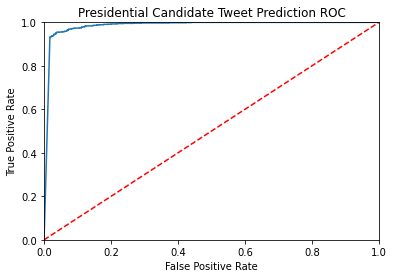

In [ ]:
# Create a list of all tweet probabilities and values
y_true = np.concatenate((np.ones(len(bidenTest)), np.zeros(len(trumpTest))))
y_scores = np.concatenate((bidenTestProbs, trumpTestProbs))

# Plot the ROC for Biden's tweets
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Presidential Candidate Tweet Prediction ROC")

AUROC = metrics.roc_auc_score(y_true, y_scores)
print("AUROC: ", AUROC)

### Side Note

As per usual in machine learning, you learn the most from looking at the misclassified items.  The code below prints the tweets from each candidate the their respective models deemed unlikely to come from its author.  The tweets from Trump that his model misclassified tend to be typically longer, more gramatically correct sentences (or sentences that he retweeted from others).  The tweets that the Biden model misclassified tend to be shorter, more agressive, and fragmented.

*Mislabeled Trump Tweets*

*   RT @NationalMallNPS: In the wake of last night's demonstrations, there are numerous instances of vandalism to sites around the National Mal… **(Confidence: ~100%)**

*   RT @senatemajldr: Small businesses, working families, and medical responders across this country have made it clear: They need help now.… **(Confidence: 99.99%)**

*   “On February 19th there was a Democratic Debate, in Las Vegas. Three words weren’t said: Virus, CoronaVirus, or COVID19. NEVER came up!” @BretBaier **(Confidence: 99.99%)**

*Mislabeled Trump Tweets*

*   Thank you, Minnesota! https://t.co/BqKfvLOJDy **(Confidence: ~100%)**

*   RT @HaleyARing: First day of action for @JoeBiden out in Buena Vista County!!! The humidity doesn’t stop #TeamJoe and @BuenaVistaDems !! **(Confidence: ~100%)**

*   Thanks, Obama. https://t.co/kBXnvbJ9ND **(Confidence: ~100%)**


In [ ]:
# Print tweets from Trump that sound like Biden
for i in range(len(trumpTest)):
  if trumpTestProbs[i] > 0.8:
    # print("i: ", i)
    print(trumpTest[i])
    print(trumpTestProbs[i])
    print("=====")

In [ ]:
# Print tweets from Biden that sound like Trump
for i in range(len(bidenTest)):
  if bidenTestProbs[i] < 0.2:
    # print("i: ", i)
    print(bidenTest[i])
    print(bidenTestProbs[i])
    print("=====")